### `DemandSupplySimulation` 環境設定方法

<p>Click to copy each command:</p>

1. **Open Terminal**  
   - Click on `Terminal` -> `New Terminal`

2. **Run Environment Creation Command**
   - Command: `conda env create -f environment.yml`  
     <button onclick="navigator.clipboard.writeText('conda env create -f environment.yml')">Copy Command</button>

3. **Update Existing Environment**  
   - Command: `conda env update -f environment.yml --prune`  
     <button onclick="navigator.clipboard.writeText('conda env update -f environment.yml --prune')">Copy Command</button>

4. **If `conda` is Not Available**  
   - Install conda mini.

### Frequently Used Commands
1. **List Existing Environment**  
   - Command: `conda env list`  
     <button onclick="navigator.clipboard.writeText('conda env list')">Copy Command</button>

### メイン（データの読み込み⇒計算）

In [ ]:
%reset -f
import pypsa, os, sys, importlib, shutil, warnings, pandas as pd, numpy as np, matplotlib.pyplot as plt
sys.path.append(os.getcwd())

# モジュールを強制的にリロード
import pypsa_tepsco
importlib.reload(pypsa_tepsco)

pd.set_option('display.max_columns', None)
os.makedirs('complete_network', exist_ok=True)
os.makedirs('combined_plots', exist_ok=True)

Year_of_analysis = 2024
demand_change_compared_to_2024 = 10  # %
file_name = "pypsa-japan-10BusModel.xlsx"  # ネットワーク＋需要データを含むExcelファイル

# Renewable Ninja API Key（取得方法: https://www.renewables.ninja/register）
renewable_ninja_api_key = "0ee68c7853037dcd2235f771d349d104e68996cf"  # ここにAPIキーを入力してください

# スナップショット作成
snapshots = pd.date_range(f"{Year_of_analysis}-08-01 00:00",
                          f"{Year_of_analysis}-08-01 23:00",
                          freq="h")
snapshots = snapshots[~((snapshots.month == 2) & (snapshots.day == 29))]

# ネットワークデータ読み込み
network = pypsa.Network(file_name)
network.set_snapshots(snapshots)

# 需要データ読み込み（同じExcelファイルの'Demand'シートから）
pypsa_tepsco.import_demand_data_from_network_file(network, file_name, demand_change_compared_to_2024)

# 太陽光発電データを自動取得
# networkのgeneratorsテーブルから太陽光発電所の座標(y, x)を自動抽出し、
# Renewable.ninja APIから時importlib.reload(pypsa_tepsco)系列データを取得
pypsa_tepsco.import_solar_data_from_renewable_ninja(network, renewable_ninja_api_key, Year_of_analysis, Year_of_analysis)

# 最適化実行
network.optimize(solver_name='highs')

# 
pypsa_tepsco.plot_total_generation_by_carrier(network)


Total Curtailment by Generator (MWh):
name
太陽光(東京)    5.456968e-12
太陽光(中部)    2.049916e-12
太陽光(関西)    6.750156e-13
太陽光(四国)    1.705303e-13
dtype: float64


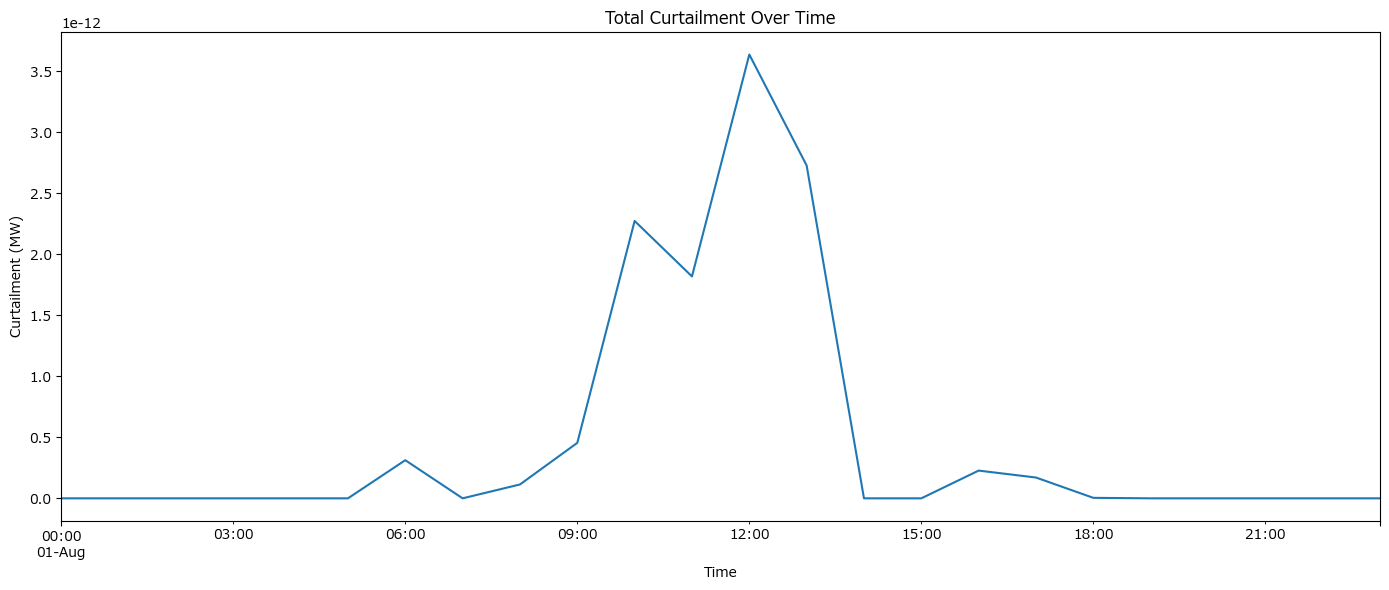


Curtailment by Carrier (MW):


carrier
その他            0.00
バイオマス          0.00
原子力            0.00
水力             0.00
火力（ガス）         0.00
火力（石油）         0.00
火力（石炭）         0.00
太陽光      -320785.93
dtype: float64

In [3]:
# ネットワークの出力抑制（curtailment）を計算して表示
curtailment = network.generators_t.p_max_pu * network.generators.p_nom - network.generators_t.p

# 各発電機の合計出力抑制量を表示
total_curtailment = curtailment.sum()
print("Total Curtailment by Generator (MWh):")
print(total_curtailment[total_curtailment > 0].sort_values(ascending=False))

# 時系列の出力抑制をプロット
curtailment_positive = curtailment.clip(lower=0)
fig, ax = plt.subplots(figsize=(14, 6))
curtailment_positive.sum(axis=1).plot(ax=ax, title='Total Curtailment Over Time', ylabel='Curtailment (MW)', xlabel='Time')
plt.tight_layout()
plt.show()

# キャリア別の出力抑制集計
curtailment_by_carrier = curtailment.T.groupby(network.generators.carrier).sum().T
print("\nCurtailment by Carrier (MW):")
curtailment_by_carrier.sum().sort_values(ascending=False)

# 送電線の潮流を表示

# 系統図上に潮流を表示

<Axes: title={'center': 'Power Flow in Transmission Lines'}, xlabel='snapshot'>

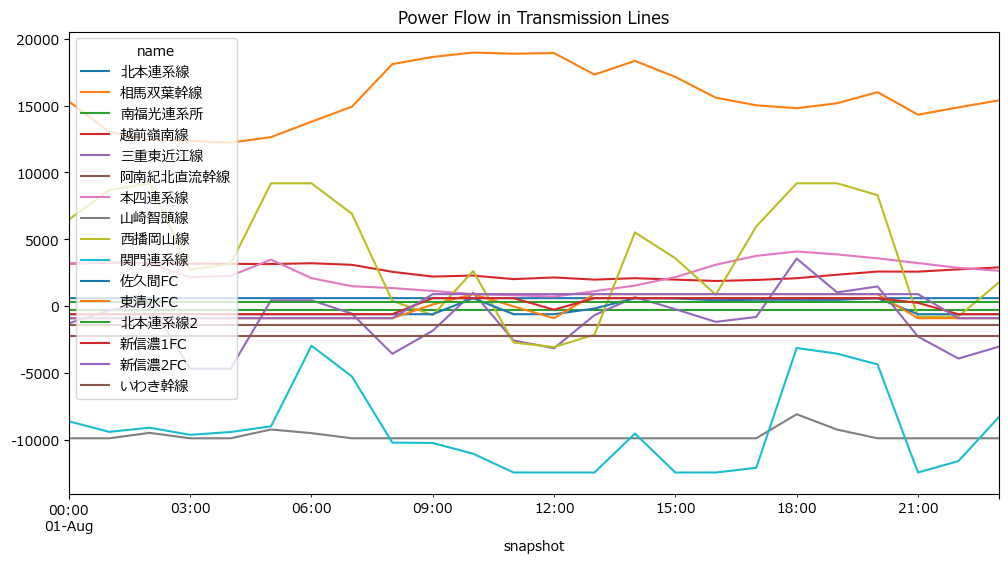

In [2]:
pd.options.plotting.backend = "matplotlib"  # プロットバックエンドをmatplotlibに
plt.rcParams['font.family'] = 'Meiryo'  # または 'Meiryo', 'Yu Gothic' MS Gothic
plt.rcParams['axes.unicode_minus'] = False  # マイナス符号も文字化け防止
network.links_t.p0.plot(title="Power Flow in Transmission Lines", figsize=(12, 6))

# 地図上にプロットする。

In [3]:
import folium
import pandas as pd

# Helper: try various column names and return DataFrame with lat/lon
def _get_bus_locations_df(network):
    df = network.buses.copy()
    # common PyPSA default: x (lon), y (lat)
    if {'y','x'}.issubset(df.columns):
        df = df.rename(columns={'y':'lat','x':'lon'})
    # already lat/lon
    elif {'lat','lon'}.issubset(df.columns):
        pass
    # alternative naming
    elif {'latitude','longitude'}.issubset(df.columns):
        df = df.rename(columns={'latitude':'lat','longitude':'lon'})
    # some workflows store coords in a list/tuple column called 'coords'
    elif 'coords' in df.columns:
        coords = df['coords'].apply(lambda v: (v[0], v[1]) if isinstance(v, (list,tuple)) and len(v)>=2 else (None,None))
        df[['lat','lon']] = pd.DataFrame(coords.tolist(), index=df.index)
    else:
        raise ValueError("network.busesに位置情報のカラムが見つかりません。期待される: x/y, lon/lat, latitude/longitude, or coords")

    # ensure numeric and drop invalid rows
    df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
    df['lon'] = pd.to_numeric(df['lon'], errors='coerce')
    df = df.dropna(subset=['lat','lon'])
    if df.empty:
        raise ValueError("有効なバス座標が見つかりません。")
    return df[['lat','lon']]

# get bus locations (raises helpful error if not found)
bus_locations = _get_bus_locations_df(network)

# 地図の中心をバスの平均位置に設定
center_lat = bus_locations['lat'].mean()
center_lon = bus_locations['lon'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=5)

# バスごとにマーカーを追加
for bus_name, row in bus_locations.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=str(bus_name),
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(m)

# 保存と表示
m.save('bus_locations_map.html')

m

In [ ]:
# プロット: バスとリンク（network.links / network.lines）を地図上に描画して保存
# 既に folium, network, Year_of_analysis が定義されている前提
import folium

# 再利用可能なバス位置取得関数 (cell '#VSC-50c70af2' と同じロジック)
def _get_bus_locations_df(network):
    df = network.buses.copy()
    if {'y','x'}.issubset(df.columns):
        df = df.rename(columns={'y':'lat','x':'lon'})
    elif {'lat','lon'}.issubset(df.columns):
        pass
    elif {'latitude','longitude'}.issubset(df.columns):
        df = df.rename(columns={'latitude':'lat','longitude':'lon'})
    elif 'coords' in df.columns:
        coords = df['coords'].apply(lambda v: (v[0], v[1]) if isinstance(v, (list,tuple)) and len(v)>=2 else (None,None))
        df[['lat','lon']] = pd.DataFrame(coords.tolist(), index=df.index)
    else:
        raise ValueError("network.busesに位置情報のカラムが見つかりません。期待される: x/y, lon/lat, latitude/longitude, or coords")

    df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
    df['lon'] = pd.to_numeric(df['lon'], errors='coerce')
    df = df.dropna(subset=['lat','lon'])
    if df.empty:
        raise ValueError("有効なバス座標が見つかりません。")
    return df[['lat','lon']]

# バス位置取得
bus_locations = _get_bus_locations_df(network)

m_links = folium.Map(location=[bus_locations['lat'].mean(), bus_locations['lon'].mean()], zoom_start=5)

# バスをマーカーで追加
for bus_name, r in bus_locations.iterrows():
    folium.CircleMarker(
        location=[r['lat'], r['lon']],
        radius=6,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.8,
        popup=str(bus_name)
    ).add_to(m_links)

# 汎用的にリンクのバス列を検出して描画する関数
def _plot_links_from_df(df, color='#d63333', weight=3, prefix=''):
    bus_cols = [c for c in df.columns if c.startswith('bus')]
    if len(bus_cols) < 2:
        return 0
    count = 0
    for name, row in df.iterrows():
        b0 = row[bus_cols[0]]
        b1 = row[bus_cols[1]]
        # bus 名が bus_locations にあるか確認
        if (b0 in bus_locations.index) and (b1 in bus_locations.index):
            coords = [
                [bus_locations.loc[b0, 'lat'], bus_locations.loc[b0, 'lon']],
                [bus_locations.loc[b1, 'lat'], bus_locations.loc[b1, 'lon']]
            ]
            popup = f"{prefix}{name}: {b0} ↔ {b1}"
            folium.PolyLine(coords, color=color, weight=weight, opacity=0.7, popup=popup).add_to(m_links)
            count += 1
    return count

# network.links があれば描画
links_plotted = 0
if hasattr(network, "links") and len(network.links) > 0:
    links_plotted += _plot_links_from_df(network.links, color='#ff4500', weight=3, prefix='link ')

# network.lines があれば描画（存在するネットワークでは lines が無い場合もある）
if hasattr(network, "lines") and len(network.lines) > 0:
    links_plotted += _plot_links_from_df(network.lines, color='#0066cc', weight=2, prefix='line ')

# 出力・保存
out_file = f'bus_links_map_{Year_of_analysis}.html'
m_links.save(out_file)
print(f"バス: {len(bus_locations)} 個、リンク描画: {links_plotted} 本。地図を保存しました -> {out_file}")

# Jupyter で表示するためにマップオブジェクトを返す
m_links


In [ ]:
# Duplicate plotting cell made robust as well
import folium

# re-use the helper from earlier; define again to be safe in isolation
def _get_bus_locations_df(network):
    df = network.buses.copy()
    if {'y','x'}.issubset(df.columns):
        df = df.rename(columns={'y':'lat','x':'lon'})
    elif {'lat','lon'}.issubset(df.columns):
        pass
    elif {'latitude','longitude'}.issubset(df.columns):
        df = df.rename(columns={'latitude':'lat','longitude':'lon'})
    elif 'coords' in df.columns:
        coords = df['coords'].apply(lambda v: (v[0], v[1]) if isinstance(v, (list,tuple)) and len(v)>=2 else (None,None))
        df[['lat','lon']] = pd.DataFrame(coords.tolist(), index=df.index)
    else:
        raise ValueError("network.busesに位置情報のカラムが見つかりません。期待される: x/y, lon/lat, latitude/longitude, or coords")

    df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
    df['lon'] = pd.to_numeric(df['lon'], errors='coerce')
    df = df.dropna(subset=['lat','lon'])
    if df.empty:
        raise ValueError("有効なバス座標が見つかりません。")
    return df[['lat','lon']]

bus_locations = _get_bus_locations_df(network)

m_links = folium.Map(location=[bus_locations['lat'].mean(), bus_locations['lon'].mean()], zoom_start=5)

# バスをマーカーで追加
for bus_name, r in bus_locations.iterrows():
    folium.CircleMarker(
        location=[r['lat'], r['lon']],
        radius=6,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.8,
        popup=str(bus_name)
    ).add_to(m_links)

# 汎用的にリンクのバス列を検出して描画する関数
def _plot_links_from_df(df, color='#d63333', weight=3, prefix=''):
    bus_cols = [c for c in df.columns if c.startswith('bus')]
    if len(bus_cols) < 2:
        return 0
    count = 0
    for name, row in df.iterrows():
        b0 = row[bus_cols[0]]
        b1 = row[bus_cols[1]]
        if (b0 in bus_locations.index) and (b1 in bus_locations.index):
            coords = [
                [bus_locations.loc[b0, 'lat'], bus_locations.loc[b0, 'lon']],
                [bus_locations.loc[b1, 'lat'], bus_locations.loc[b1, 'lon']]
            ]
            popup = f"{prefix}{name}: {b0} ↔ {b1}"
            folium.PolyLine(coords, color=color, weight=weight, opacity=0.7, popup=popup).add_to(m_links)
            count += 1
    return count

links_plotted = 0
if hasattr(network, "links") and len(network.links) > 0:
    links_plotted += _plot_links_from_df(network.links, color='#ff4500', weight=3, prefix='link ')

if hasattr(network, "lines") and len(network.lines) > 0:
    links_plotted += _plot_links_from_df(network.lines, color='#0066cc', weight=2, prefix='line ')

out_file = f'bus_links_map_{Year_of_analysis}.html'
m_links.save(out_file)
print(f"バス: {len(bus_locations)} 個、リンク描画: {links_plotted} 本。地図を保存しました -> {out_file}")

m_links
